# FA24 - Assignment 5 - RNN and LSTM


**Instructions**
- Download the dataset from Moodle.
- Do **NOT** forget to type in your name and AUBNET After this cell.
- Do **NOT** upload the dataset with your submission.
- Name the assignment as follows: **Ast5_AUBNET.ipynb** . Failure to follow this naming convention will result in the notebook **not being graded**.
- For this assignment, you are required to utilize only the specified imported libraries for each section. Please refrain from changing or substituting the libraries provided. Failure to comply with this requirement may result in the assignment not being graded or may lead to delays until the end of the semester.


**NOTE:**
- **If an assignment contains a copied solution, the entire assignment will be awarded 0 points for all individuals submitting the same solution. Furthermore, any solutions generated by AI tools, will also receive 0 points.**

In [ ]:
# Ralph Mouawad - rmm85- 202204667
# CMPS 364 - Advanced ML - Dr. Shady Elbassuoni
# HW 5 - NLP - Image Captioning

In [1]:
from utils import *
from grad import *
from grad_optimizer import *
from model_layers import *
from trainer import *
from rnn_model import *

In [2]:
import os
import time
import json

import numpy as np
import matplotlib.pyplot as plt

# %matplotlib inline: This ensures that the plots generated by matplotlib are displayed inline in Jupyter notebooks.
%matplotlib inline

# Configure default plotting behavior
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # Set the default size for plots to 10x8 inches
plt.rcParams['image.interpolation'] = 'nearest'  # Set the interpolation for images to 'nearest' (no smoothing)
plt.rcParams['image.cmap'] = 'gray'  # Set the default colormap for images to grayscale


def rel_error(x, y):
    """Compute the relative error between two arrays.

    The relative error is calculated as the element-wise absolute difference between
    two arrays `x` and `y`, divided by the maximum of the absolute values of `x` and `y`
    (to avoid division by zero). A small constant (1e-8) is used to prevent numerical instability.

    Args:
        x (numpy.ndarray): First array.
        y (numpy.ndarray): Second array, typically the ground truth or reference.

    Returns:
        numpy.ndarray: The relative error computed for each element in `x` and `y`.
    """
    # Compute the relative error
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))  # Return the maximum relative error


# COCO Dataset Overview

For this exercise, we will use the 2014 release of the [COCO dataset](https://cocodataset.org/), a comprehensive image captioning benchmark. This dataset features 80,000 training images and 40,000 validation images, each annotated with 5 unique captions crafted by Amazon Mechanical Turk workers.

**Image Features.** We have preprocessed the image data and extracted features for you in advance. All images have image features extracted from the fc7 layer of the VGG-16 network, which was pretrained on ImageNet. These features are stored in two key files:
- `train2014_vgg16_fc7.h5`: Full-dimensional training image features
- `val2014_vgg16_fc7.h5`: Full-dimensional validation image features

To optimize processing time and memory efficiency, we've applied Principal Component Analysis (PCA) to reduce feature dimensionality from 4096 to 512. These reduced features are available in:
- `train2014_vgg16_fc7_pca.h5`: Dimensionality-reduced training image features
- `val2014_vgg16_fc7_pca.h5`: Dimensionality-reduced validation image features

Due to the substantial storage requirements (nearly 20GB), the raw images are not included in the download. However, since all images originate from Flickr, we've included URLs for both training and validation images in:
- `train2014_urls.txt`: Training image URLs
- `val2014_urls.txt`: Validation image URLs
These URLs enable on-the-fly image downloading for visualization purposes.

**Caption Encoding.** To enhance computational efficiency, we work with an integer-encoded representation of captions. Each word is assigned a unique integer ID, allowing captions to be represented as integer sequences. Key resources include:
- `coco2014_vocab.json`: Mapping between integer IDs and words
- `utils.py`: Contains `decode_captions` function to convert integer ID arrays back to readable strings

**Special Tokens.** We've implemented several specialized tokens to facilitate caption processing:
- `<START>`: Prepended to the beginning of each caption
- `<END>`: Appended to the end of each caption
- `<UNK>`: Represents "unknown" words, replacing rare vocabulary items
- `<NULL>`: Used for padding captions to enable consistent minibatch processing

To load all COCO data components (captions, image features, URLs, and vocabulary), use the `load_coco_dataset` function from `utils.py`. Execute the following cell to initiate data loading:


In [3]:
!unzip -qu "coco_captioning.zip" -d datasets/

In [4]:
# Define the base directory for the COCO dataset
dir_path = os.path.dirname("/content/")
BASE_DIR = os.path.join(dir_path, "datasets/coco_captioning")



# Load the COCO dataset into a dictionary.
# The `load_coco_dataset` function loads various data files related to COCO captions and image features.
# By setting `pca_features=True`, we load dimensionality-reduced features (PCA-reduced).
# You can set this to False to experiment with the original features instead.
data = load_coco_dataset(BASE_DIR, max_train=None, pca_features=True)

# Print out the keys and corresponding values from the data dictionary.
# This provides insight into the structure of the loaded data, including types, shapes, and sizes of arrays.
# If the value is a numpy array, we print its shape and data type.
# If it's a list or other type, we print the length of the object.

for key, value in data.items():
    if isinstance(value, np.ndarray):  # Check if the value is a numpy array
        print(key, type(value), value.shape, value.dtype)  # Print key, type, shape, and data type of the array
    else:
        print(key, type(value), len(value))  # Print key, type, and length of the object if it's not an ndarray

base dir  /content/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## Data Exploration and Visualization

Before diving into the dataset, it’s beneficial to explore some examples to better understand its structure and content.

The `get_coco_minibatch` function, located in `utils.py`, allows you to extract minibatches from the dataset provided by `load_coco_data`. To try it out, run the following code snippet to retrieve a small training minibatch and display the corresponding images and captions. Running this function multiple times and reviewing the output can give you a clearer sense of what the dataset contains.

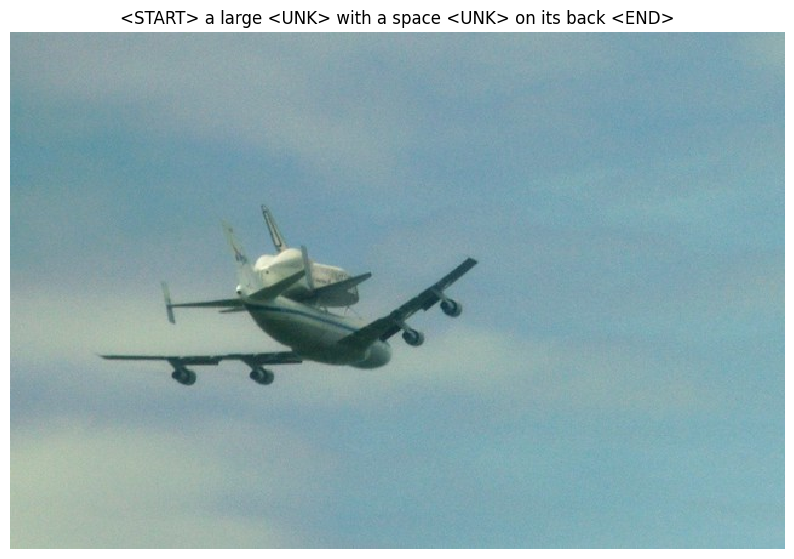

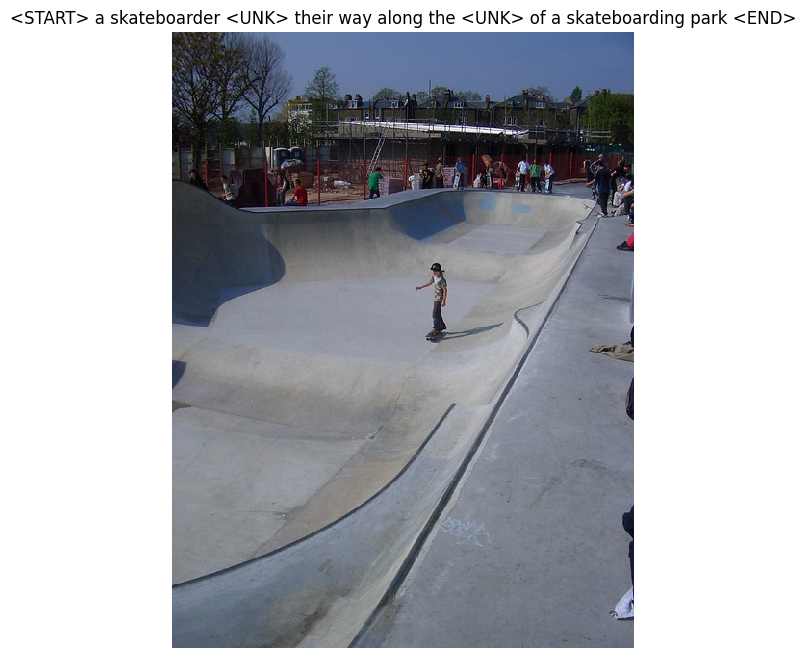

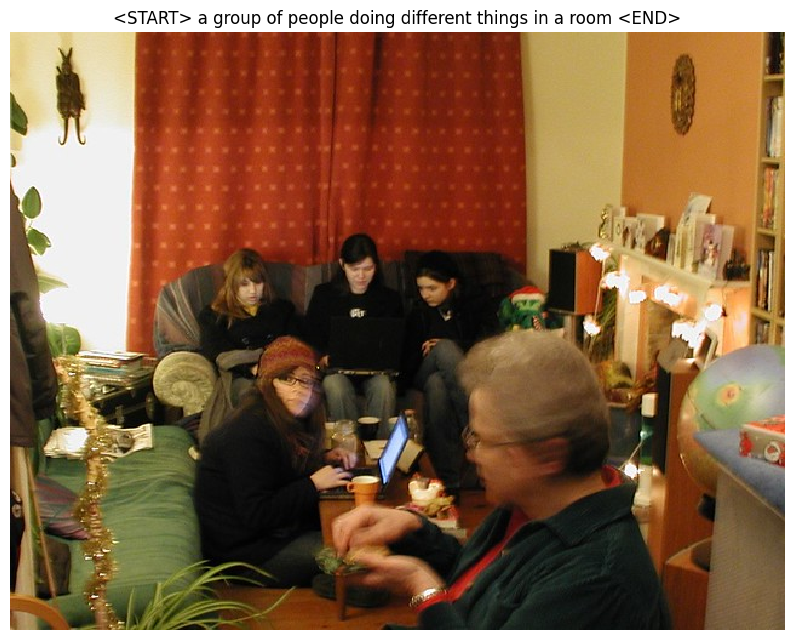

In [27]:
import matplotlib.pyplot as plt
import numpy as np

batch_size = 3

ground_truth_captions, image_features, urls = get_coco_minibatch(data, minibatch_size=batch_size)
for i, (caption, url) in enumerate(zip(ground_truth_captions, urls)):
    try:
        # Attempt to load and display the image
        img = image_from_url(url)
        plt.imshow(img)
        plt.axis('off')

        # Decode and display the caption
        caption_str = decode_captions(caption, data['idx_to_word'])
        plt.title(caption_str)
        plt.show()

    except Exception as e:
        # If an error occurs (e.g., URL not found), skip and print a warning
        print(f"Warning: Failed to load image from URL: {url}. Skipping this sample.")
        continue  # Skip to the next sample



# Image Captioning with Recurrent Neural Networks

Ever wondered how computers can look at an image and describe what they see? That's exactly what we'll explore by building an image captioning system using Recurrent Neural Networks (RNNs). This powerful architecture helps our model learn to generate natural language descriptions of images, word by word.

Our implementation is split across two key files:
- `model_layers.py` contains the fundamental RNN layer implementations that form the building blocks of our system
- `rnn_model.py` brings these layers together to create our complete image captioning model

To get started, you'll implement several types of RNN layers in `model_layers.py`. These layers will serve as the foundation for our image captioning system.

## Building the Core RNN Logic:


### Forward Step Propagation Implementation:

Let's dive into the fundamental mechanics of our Recurrent Neural Network by implementing its forward processing logic. You'll be working in `model_layers.py`, which houses the essential building blocks for our RNN architecture.

Your first challenge is to complete the `foward_propg_step` function - this is where the actual "thinking" happens in our RNN. This function processes incoming data and updates the network's internal memory, forming the foundation for how our network learns patterns over sequences.

Head over to `model_layers.py` and implement the function. Once you're done, verify your work using the provided test suite. Your implementation should be mathematically precise - we're looking for calculation errors **smaller than 10^-8**.

In [6]:
# Define dimensions for our image captioning RNN
num_samples = 3        # Number of images we process at once
vocab_size = 10       # Size of our word embedding/input features
hidden_size = 4       # Size of RNN's memory/hidden state

# Create test data for our RNN forward pass
# For reproducible testing, we'll generate structured data using np.linspace

# Input data: Represents embedded words from captions
# Shape: (3 images × 10 embedding dimensions)
x = np.linspace(-0.4, 0.7, num=num_samples*vocab_size).reshape(num_samples, vocab_size)

# Previous hidden state: RNN's memory of earlier words in the caption
# Shape: (3 images × 4 hidden dimensions)
prev_hidden = np.linspace(-0.2, 0.5, num=num_samples*hidden_size).reshape(num_samples, hidden_size)

# Weight matrices for our RNN:
# word_weights: Transforms word embeddings to hidden state space
# memory_weights: Processes the previous caption context
word_weights = np.linspace(-0.1, 0.9, num=vocab_size*hidden_size).reshape(vocab_size, hidden_size)
memory_weights = np.linspace(-0.3, 0.7, num=hidden_size*hidden_size).reshape(hidden_size, hidden_size)

# Bias: Helps RNN learn caption patterns
# Shape: (4 hidden dimensions)
bias = np.linspace(-0.2, 0.4, num=hidden_size)

# Process one word through our RNN
# Combines current word with previous caption context to predict next word
next_hidden_state, _ = foward_propg_step(x, prev_hidden, word_weights, memory_weights, bias)

# Expected outputs for this test case
expected_next_hidden_state = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

# Verify our RNN processes words correctly
print('Relative error in next hidden state: ', rel_error(expected_next_hidden_state, next_hidden_state))

Relative error in next hidden state:  6.292421426471037e-09


### Backward Step Propagation Implementation:


Implement the backpropagation calculation for one time step in a basic RNN within the file `model_layers.py`. Specifically, you need to code the `backward_propg_step` function that handles gradient computation for a single RNN step.
After you've written the implementation, validate it using the test suite, which will compare your gradients against numerically computed ones. Your implementation should be accurate - the difference between your analytical gradients and the numerical ones should be very small (approximately **10^-8 or less**).

In [7]:
# Set random seed for reproducibility in testing
np.random.seed(231)

# Define dimensions for our image captioning RNN
num_samples = 4       # Number of images we'll process at once
vocab_size = 5       # Size of our word embeddings
hidden_size = 6      # Size of RNN's memory/hidden state

# Generate random test data for gradient checking
# word_features: Current word embeddings for each image caption
# prev_context: What RNN remembers about previous words in captions
# word_weights: Transforms word embeddings into hidden state space
# memory_weights: Processes previous caption context
# bias: Helps RNN learn caption patterns
word_features = np.random.randn(num_samples, vocab_size)
prev_context = np.random.randn(num_samples, hidden_size)
word_weights = np.random.randn(vocab_size, hidden_size)
memory_weights = np.random.randn(hidden_size, hidden_size)
bias = np.random.randn(hidden_size)

# Process one word through our RNN
next_context, cache_data = foward_propg_step(word_features, prev_context, word_weights, memory_weights, bias)

# Create random gradient for testing backpropagation
# This simulates the gradient coming from future words in the caption
dnext_context = np.random.randn(*next_context.shape)

# Define functions for numerical gradient checking
# These help verify our backpropagation implementation is correct
fx = lambda word_features: foward_propg_step(word_features, prev_context, word_weights, memory_weights, bias)[0]
fh = lambda prev_context: foward_propg_step(word_features, prev_context, word_weights, memory_weights, bias)[0]
fw = lambda word_weights: foward_propg_step(word_features, prev_context, word_weights, memory_weights, bias)[0]
fm = lambda memory_weights: foward_propg_step(word_features, prev_context, word_weights, memory_weights, bias)[0]
fb = lambda bias: foward_propg_step(word_features, prev_context, word_weights, memory_weights, bias)[0]

# Calculate numerical gradients
dword_num = eval_num_grad_array(fx, word_features, dnext_context)
dcontext_num = eval_num_grad_array(fh, prev_context, dnext_context)
dword_weights_num = eval_num_grad_array(fw, word_weights, dnext_context)
dmemory_weights_num = eval_num_grad_array(fm, memory_weights, dnext_context)
dbias_num = eval_num_grad_array(fb, bias, dnext_context)

# Compute gradients using backpropagation
dword, dcontext, dword_weights, dmemory_weights, dbias = backward_propg_step(dnext_context, cache_data)

# Verify our backpropagation is working correctly by comparing with numerical gradients
print('Error in word features gradient: ', rel_error(dword_num, dword))
print('Error in context gradient: ', rel_error(dcontext_num, dcontext))
print('Error in word weights gradient: ', rel_error(dword_weights_num, dword_weights))
print('Error in memory weights gradient: ', rel_error(dmemory_weights_num, dmemory_weights))
print('Error in bias gradient: ', rel_error(dbias_num, dbias))

Error in word features gradient:  3.012195314688577e-10
Error in context gradient:  2.682836380610124e-10
Error in word weights gradient:  8.845250330498008e-10
Error in memory weights gradient:  1.1775809691570525e-10
Error in bias gradient:  1.75514782279763e-11


### Complete Forward Implementation:

Having implemented the forward and backward functions, the next step is to extend this to handle an entire sequence of data.

In the `model_layers.py` file, implement the `foward_propg_rnn` function, which should utilize the `foward_propg_step` function you previously created. Once you’ve completed the implementation, run the provided tests to verify it. The expected error margin should be around **e-7 or smaller**.

In [8]:
# Define dimensions for our image captioning RNN test case
num_samples = 2        # Number of images we process at once
caption_length = 3     # Length of captions we'll generate
vocab_size = 4        # Size of our word embeddings
hidden_size = 5       # Size of RNN's memory state

# Create test sequence of word embeddings for our captions
# Shape: (2 images × 3 words × 4 embedding dimensions)
word_sequence = np.linspace(-0.1, 0.3, num=num_samples*caption_length*vocab_size).reshape(num_samples, caption_length, vocab_size)

# Initialize RNN's starting memory state for each image
# Shape: (2 images × 5 hidden dimensions)
initial_context = np.linspace(-0.3, 0.1, num=num_samples*hidden_size).reshape(num_samples, hidden_size)

# Initialize learnable weights for our RNN
# word_weights: Transforms word embeddings into memory space
# Shape: (4 embedding dimensions → 5 hidden dimensions)
word_weights = np.linspace(-0.2, 0.4, num=vocab_size*hidden_size).reshape(vocab_size, hidden_size)

# memory_weights: Processes previous caption context
# Shape: (5 hidden dimensions → 5 hidden dimensions)
memory_weights = np.linspace(-0.4, 0.1, num=hidden_size*hidden_size).reshape(hidden_size, hidden_size)

# bias: Helps RNN learn caption patterns
# Shape: (5 hidden dimensions)
bias = np.linspace(-0.7, 0.1, num=hidden_size)

# Process entire caption sequence through RNN
# Returns memory states for each word in the caption
caption_states, _ = foward_propg_rnn(word_sequence, initial_context, word_weights, memory_weights, bias)

# Expected memory states after processing each word
# Shape: (2 images × 3 words × 5 hidden dimensions)
expected_states = np.asarray([
 [
   [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
   [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
   [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
 ],
 [
   [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
   [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
   [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]
 ]
])

# Check if our RNN processes captions correctly
error = rel_error(expected_states, caption_states)

# Report accuracy of our implementation
print(f"RNN caption processing accuracy (relative error): {error:.6e}")

RNN caption processing accuracy (relative error): 7.728466e-08


### Complete Backward Implementation:

Implement the backpropagation in the `model_layers.py` file by coding the `backward_propg_rnn` function. It should work by calling `backward_propg_step` repeatedly for each timestep in the sequence.
To verify your implementation, run the tests - they'll check if your gradients are correct. Your implementation should be precise enough that the difference between your calculated gradients and the numerically computed ones is around **10^-6 or smaller**.

In [9]:
# Set random seed for reproducible testing
np.random.seed(231)

# Define dimensions for our image captioning RNN
num_samples = 2       # Number of images to process
vocab_size = 3       # Size of word embeddings
caption_length = 10   # Maximum words in a caption
hidden_size = 5      # Size of RNN's memory state

# Generate random test data
# Random sequence of word embeddings for each image's caption
word_sequence = np.random.randn(num_samples, caption_length, vocab_size)
# Initial memory state for each image
initial_context = np.random.randn(num_samples, hidden_size)
# Learnable parameters for our RNN
word_weights = np.random.randn(vocab_size, hidden_size)    # Transform words to memory space
memory_weights = np.random.randn(hidden_size, hidden_size) # Process caption context
bias = np.random.randn(hidden_size)                        # Learn caption patterns

# Process full caption sequences through RNN
caption_states, cache_data = foward_propg_rnn(word_sequence, initial_context, word_weights, memory_weights, bias)

# Generate random upstream gradients for testing backprop
upstream_gradients = np.random.randn(*caption_states.shape)

# Compute gradients using backpropagation
grad_word_seq, grad_init_context, grad_word_weights, grad_memory_weights, grad_bias = backward_propg_rnn(upstream_gradients, cache_data)

# Define functions for numerical gradient verification
fx = lambda word_sequence: foward_propg_rnn(word_sequence, initial_context, word_weights, memory_weights, bias)[0]
fic = lambda initial_context: foward_propg_rnn(word_sequence, initial_context, word_weights, memory_weights, bias)[0]
fww = lambda word_weights: foward_propg_rnn(word_sequence, initial_context, word_weights, memory_weights, bias)[0]
fmw = lambda memory_weights: foward_propg_rnn(word_sequence, initial_context, word_weights, memory_weights, bias)[0]
fb = lambda bias: foward_propg_rnn(word_sequence, initial_context, word_weights, memory_weights, bias)[0]

# Calculate numerical gradients for verification
grad_word_seq_num = eval_num_grad_array(fx, word_sequence, upstream_gradients)
grad_init_context_num = eval_num_grad_array(fic, initial_context, upstream_gradients)
grad_word_weights_num = eval_num_grad_array(fww, word_weights, upstream_gradients)
grad_memory_weights_num = eval_num_grad_array(fmw, memory_weights, upstream_gradients)
grad_bias_num = eval_num_grad_array(fb, bias, upstream_gradients)

# Compare backprop gradients with numerical approximations
print('Word sequence gradient error: ', rel_error(grad_word_seq_num, grad_word_seq))
print('Initial context gradient error: ', rel_error(grad_init_context_num, grad_init_context))
print('Word weights gradient error: ', rel_error(grad_word_weights_num, grad_word_weights))
print('Memory weights gradient error: ', rel_error(grad_memory_weights_num, grad_memory_weights))
print('Bias gradient error: ', rel_error(grad_bias_num, grad_bias))

Word sequence gradient error:  1.5329671902666274e-09
Initial context gradient error:  3.3841556053952788e-09
Word weights gradient error:  7.254141603192443e-09
Memory weights gradient error:  1.2984496079605408e-07
Bias gradient error:  2.2778694382410027e-10


### Forward Word Embedding Implementation:
In deep learning models, words are typically represented as vectors. Each word in the vocabulary is assigned a vector, which is learned alongside the other components of the system.

In the `model_layers.py` file, implement the `forward_word_embedding` function to transform words (represented by integers) into corresponding word vectors. After completing the implementation, run the provided test to validate it. The expected error should be around **e-8 or smaller**.

In [10]:
# Define dimensions for our image captioning word embeddings
num_samples = 2      # Number of images to process
caption_length = 4   # Words per caption
vocab_size = 5      # Total unique words in vocabulary
embed_dim = 3       # Dimensions for each word embedding

# Sample caption sequences using word indices
# Each number represents a word in our vocabulary (0-4)
caption_indices = np.asarray([
   [0, 3, 1, 2],   # Caption for first image
   [2, 1, 0, 3]    # Caption for second image
])

# Create embedding matrix: maps each word to its feature vector
# Each row represents one word's embedding vector
word_embeddings = np.linspace(0, 1, num=vocab_size*embed_dim).reshape(vocab_size, embed_dim)

# Convert word indices to their corresponding embedding vectors
embedded_captions, _ = forward_word_embedding(caption_indices, word_embeddings)

# Expected embedding vectors for each word in the captions
expected_embeddings = np.asarray([
[[ 0.,          0.07142857,  0.14285714],  # First caption
 [ 0.64285714,  0.71428571,  0.78571429],
 [ 0.21428571,  0.28571429,  0.35714286],
 [ 0.42857143,  0.5,         0.57142857]],
[[ 0.42857143,  0.5,         0.57142857],  # Second caption
 [ 0.21428571,  0.28571429,  0.35714286],
 [ 0.,          0.07142857,  0.14285714],
 [ 0.64285714,  0.71428571,  0.78571429]]])

# Verify our embedding lookup works correctly
print('Word embedding lookup error: ', rel_error(expected_embeddings, embedded_captions))

Word embedding lookup error:  1.0000000094736443e-08


### Backward Word Embedding Implementation:
Implement the backward propagation for the word embedding function in the `backward_word_embedding` function. Once you’ve completed the implementation, run the provided test to perform a numerical gradient check. The expected error should be around **e-11 or smaller**.

In [11]:
# Set random seed for reproducible testing
np.random.seed(231)

# Define dimensions for word embedding layer
num_samples = 50     # Number of images to process
caption_length = 3   # Words per caption
vocab_size = 5      # Total unique words in vocabulary
embed_dim = 6       # Dimensions for each word embedding

# Generate random caption data
# Each number (0-4) represents a word in our vocabulary
caption_indices = np.random.randint(vocab_size, size=(num_samples, caption_length))

# Initialize random word embeddings
# Each row is a word's feature vector
word_embeddings = np.random.randn(vocab_size, embed_dim)

# Convert word indices to embedding vectors
embedded_captions, cache_data = forward_word_embedding(caption_indices, word_embeddings)

# Generate random upstream gradients for testing backprop
upstream_gradients = np.random.randn(*embedded_captions.shape)

# Compute gradients for word embeddings using backpropagation
grad_word_embeddings = backward_word_embedding(upstream_gradients, cache_data)

# Define function for numerical gradient checking
f = lambda word_embeddings: forward_word_embedding(caption_indices, word_embeddings)[0]

# Calculate numerical gradients for verification
grad_word_embeddings_num = eval_num_grad_array(f, word_embeddings, upstream_gradients)

# Verify our gradient computation is correct
print('Word embedding gradient error: ', rel_error(grad_word_embeddings, grad_word_embeddings_num))

Word embedding gradient error:  3.2774595693100364e-12


### Sequential Layer Implementation:

At each timestep, our RNN converts its internal hidden state into predictions across our vocabulary. This conversion process has already been implemented for you in `model_layers.py` through two functions: `temp_forward_layer` and `temp_backward_layer`.
Since this functionality is complete, your task is simply to run the provided tests to ensure everything works correctly. These tests check the accuracy of the gradient calculations by comparing them to numerically computed values. If the implementation is correct, you'll see very small differences between these two approaches - specifically around **10^-9 or smaller**.

In [12]:
# Set random seed for reproducible testing
np.random.seed(231)

# Define dimensions for temporal affine layer
num_samples = 2      # Number of images to process
caption_length = 3   # Words per caption
input_dim = 4       # Input feature dimensions (from RNN)
output_dim = 5      # Output dimensions (vocabulary size)

# Generate random test data
# RNN hidden states for each word in the captions
hidden_states = np.random.randn(num_samples, caption_length, input_dim)

# Learnable parameters
# Transform RNN outputs to vocabulary scores
projection_weights = np.random.randn(input_dim, output_dim)
projection_bias = np.random.randn(output_dim)

# Project RNN outputs to vocabulary space
vocab_scores, cache_data = temp_forward_layer(hidden_states, projection_weights, projection_bias)

# Generate random upstream gradients for testing backprop
upstream_gradients = np.random.randn(*vocab_scores.shape)

# Define functions for numerical gradient verification
f_hidden = lambda hidden_states: temp_forward_layer(hidden_states, projection_weights, projection_bias)[0]
f_weights = lambda projection_weights: temp_forward_layer(hidden_states, projection_weights, projection_bias)[0]
f_bias = lambda projection_bias: temp_forward_layer(hidden_states, projection_weights, projection_bias)[0]

# Calculate numerical gradients for verification
grad_hidden_num = eval_num_grad_array(f_hidden, hidden_states, upstream_gradients)
grad_weights_num = eval_num_grad_array(f_weights, projection_weights, upstream_gradients)
grad_bias_num = eval_num_grad_array(f_bias, projection_bias, upstream_gradients)

# Compute gradients using backpropagation
grad_hidden, grad_weights, grad_bias = temp_backward_layer(upstream_gradients, cache_data)

# Verify our gradient computations are correct
print('Hidden state gradient error: ', rel_error(grad_hidden_num, grad_hidden))
print('Projection weights gradient error: ', rel_error(grad_weights_num, grad_weights))
print('Projection bias gradient error: ', rel_error(grad_bias_num, grad_bias))

Hidden state gradient error:  2.9215945034030545e-10
Projection weights gradient error:  1.5772088618663602e-10
Projection bias gradient error:  3.252200556967514e-11


###  Softmax Loss

Run the test suite to verify the sequential layer's gradient calculations. The test will compare the computed gradients against numerical approximations - if everything is working correctly, the difference between these values should be extremely small (approximately **10^-9 or less**).

In [13]:
# Define initial test dimensions
samples, time_steps, dictionary_size = 100, 1, 10

def validate_loss(samples, time_steps, dictionary_size, mask_prob):
    """
    Validates loss calculation with random input data and masking
    """
    # Generate small random input features
    features = 0.001 * np.random.randn(samples, time_steps, dictionary_size)
    # Create random target labels
    labels = np.random.randint(dictionary_size, size=(samples, time_steps))
    # Generate random mask based on probability
    attention_mask = np.random.rand(samples, time_steps) <= mask_prob
    # Calculate and display loss
    print(masked_softmax_loss(features, labels, attention_mask)[0])

# Test cases with different configurations
validate_loss(100, 1, 10, 1.0)    # Expected result: ~2.3
validate_loss(100, 10, 10, 1.0)   # Expected result: ~23
validate_loss(5000, 10, 10, 0.1)  # Expected result: between 2.2-2.4

# Numerical gradient validation setup
samples, time_steps, dictionary_size = 7, 8, 9
features = np.random.randn(samples, time_steps, dictionary_size)
labels = np.random.randint(dictionary_size, size=(samples, time_steps))
attention_mask = (np.random.rand(samples, time_steps) > 0.5)

# Compute gradients and validate
computed_loss, gradient = masked_softmax_loss(features, labels, attention_mask, ver=False)
numerical_gradient = eval_num_grad(lambda x: masked_softmax_loss(x, labels, attention_mask)[0],
                                 features, ver=False)
print('Gradient error: ', rel_error(gradient, numerical_gradient))

2.3027781774290146
23.025985953127226
2.2643611790293394
Gradient error:  8.254163750278127e-08


### Final Model

With your building blocks in place, it's time to construct the complete text prediction system. Implement both the forward and backward computations `rnn_model.py` inside the model's loss function (specified by `cell_type='rnn'`). Run the below cell afterwards, you should see numerical errors around **e-10 or less** if everything is working correctly.

In [14]:
# Initialize dimensions for the image captioning model
num_samples, feature_dim, embedding_size, rnn_size = 10, 20, 30, 40

# Define vocabulary mapping with special tokens
vocabulary_map = {
    '<NULL>': 0,
    'cat': 2,
    'dog': 3
}
vocab_size = len(vocabulary_map)
caption_length = 13

# Initialize the RNN-based image captioning model
caption_model = ImageCaptioningRNN(
    vocabulary_map,
    input_dim=feature_dim,
    wordvec_dim=embedding_size,
    hidden_dim=rnn_size,
    cell_type='rnn',
    dtype=np.float64
)

# Initialize model parameters with deterministic values for testing
for param_name, param_array in caption_model.params.items():
    caption_model.params[param_name] = np.linspace(
        -1.4, 1.3,
        num=param_array.size
    ).reshape(*param_array.shape)

# Generate synthetic image features and captions for testing
img_features = np.linspace(
    -1.5, 0.3,
    num=(num_samples * feature_dim)
).reshape(num_samples, feature_dim)

target_captions = (
    np.arange(num_samples * caption_length) % vocab_size
).reshape(num_samples, caption_length)

# Compute model loss and gradients
computed_loss, gradients = caption_model.loss(img_features, target_captions)

# Validate against reference loss value
reference_loss = 9.83235591003
print('loss: ', computed_loss)
print('expected loss: ', reference_loss)
print('difference: ', abs(computed_loss - reference_loss))

loss:  9.832355910027387
expected loss:  9.83235591003
difference:  2.6130209107577684e-12


Run the code below to validate your `ImageCaptioningRNN` class. A passing test should result in errors around **e-6 or smaller**, confirming that your gradients are computed correctly.

In [15]:
# Set random seed for reproducibility
np.random.seed(231)

# Define model architecture dimensions
num_samples = 2
sequence_length = 3
feature_size = 4
embedding_dim = 5
rnn_units = 6

# Initialize vocabulary dictionary with special tokens
token_to_index = {
    '<NULL>': 0,
    'cat': 2,
    'dog': 3
}
dict_size = len(token_to_index)

# Generate synthetic training data
target_sequences = np.random.randint(dict_size, size=(num_samples, sequence_length))
input_features = np.random.randn(num_samples, feature_size)

# Initialize image captioning model
caption_generator = ImageCaptioningRNN(
    token_to_index,
    input_dim=feature_size,
    wordvec_dim=embedding_dim,
    hidden_dim=rnn_units,
    cell_type='rnn',
    dtype=np.float64,
)

# Compute loss and gradients
computed_loss, computed_gradients = caption_generator.loss(input_features, target_sequences)

# Validate gradients using numerical approximation
for param_name in sorted(computed_gradients):
    # Define loss function for numerical gradient computation
    loss_func = lambda x: caption_generator.loss(input_features, target_sequences)[0]

    # Calculate numerical gradient
    numerical_gradient = eval_num_grad(
        loss_func,
        caption_generator.params[param_name],
        h=1e-6,
        ver=False
    )

    # Compare numerical and analytical gradients
    gradient_error = rel_error(numerical_gradient, computed_gradients[param_name])
    print('%s relative error: %e' % (param_name, gradient_error))

W_embedding relative error: 2.331071e-09
W_project relative error: 9.974425e-09
W_vocab relative error: 4.274378e-09
b_proj relative error: 1.000000e+00
b_vocab relative error: 7.087090e-11
bias relative error: 9.727212e-10
hidden_weights relative error: 1.313259e-08
input_weights relative error: 8.455229e-07


### Testing Model on Small Dataset

Use the `ImageCaptioningTrainerEngine` class from `trainer.py` to train your model. Run the code below to verify it can overfit on 100 training examples - the loss should drop **below 0.1**.

base dir  /content/datasets/coco_captioning
(Iteration 1 / 100) loss: 76.913487
(Iteration 11 / 100) loss: 21.039593
(Iteration 21 / 100) loss: 4.061741
(Iteration 31 / 100) loss: 0.560403
(Iteration 41 / 100) loss: 0.238701
(Iteration 51 / 100) loss: 0.162945
(Iteration 61 / 100) loss: 0.113132
(Iteration 71 / 100) loss: 0.097639
(Iteration 81 / 100) loss: 0.098608
(Iteration 91 / 100) loss: 0.074115


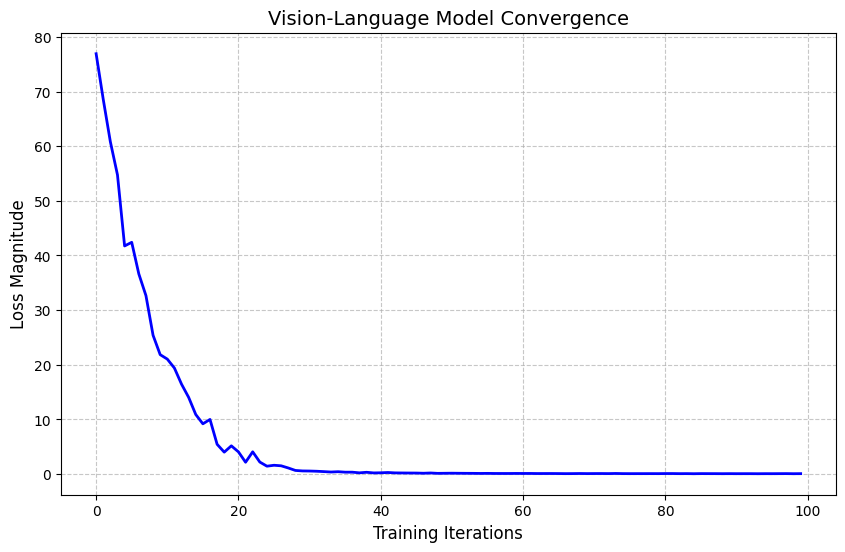

In [16]:
# Enable deterministic initialization
np.random.seed(231)
from utils import get_coco_minibatch
# Initialize training corpus with subset of images
coco_dataset = load_coco_dataset(
    base_dir=BASE_DIR,
    max_train=50
)

# Construct vision-language architecture
vision_decoder = ImageCaptioningRNN(
    cell_type='rnn',
    word_to_idx=data['word_to_idx'],
    input_dim=data['train_features'].shape[1],
    hidden_dim=512,  # Memory state dimension
    wordvec_dim=256,  # Text embedding dimension
)

# Initialize training orchestrator
orchestrator = ImageCaptioningTrainerEngine(
    model=vision_decoder,
    data=coco_dataset,
    update_opt='adam',      # Optimization strategy
    n_epoch=50,            # Total training cycles
    batch_size=25,         # Samples per iteration
    opt_config={
        'learning_rate': 5e-3,  # Initial step size
    },
    lr_decay=0.95,         # Learning rate decay factor
    ver=True,              # Verbose execution
    print_all=10,          # Status update frequency
)

# Launch training procedure
orchestrator.train()

# Generate performance visualization
plt.figure(figsize=(10, 6))
plt.plot(orchestrator.loss_history, color='blue', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Training Iterations', fontsize=12)
plt.ylabel('Loss Magnitude', fontsize=12)
plt.title('Vision-Language Model Convergence', fontsize=14)
plt.show()

Print final training loss. You should see a final loss of less than 0.1.

In [17]:
print('Expected Final loss: ', orchestrator.loss_history[-1])

Expected Final loss:  0.08213306044473924


### Generation at Test Time

In `rnn_model.py`:
1. Complete the code of `sample` function
2. Test by generating text using:
    - Training data (should produce coherent results)
    - Validation data (lower quality because we are overfitting)

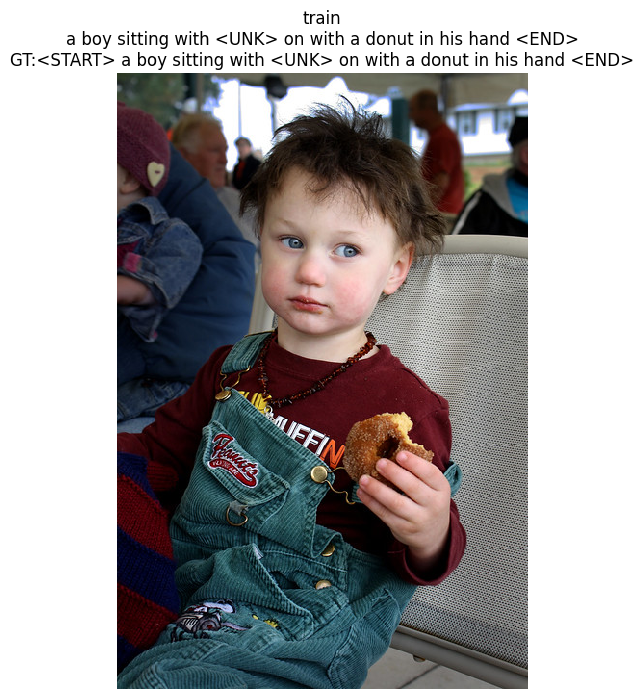

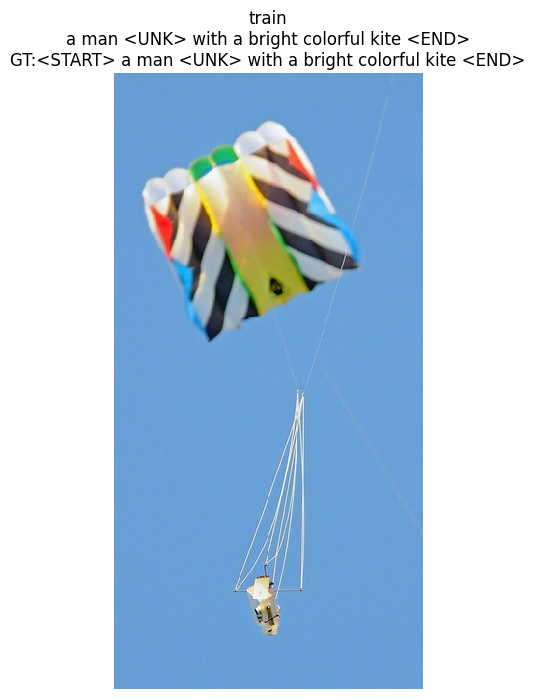

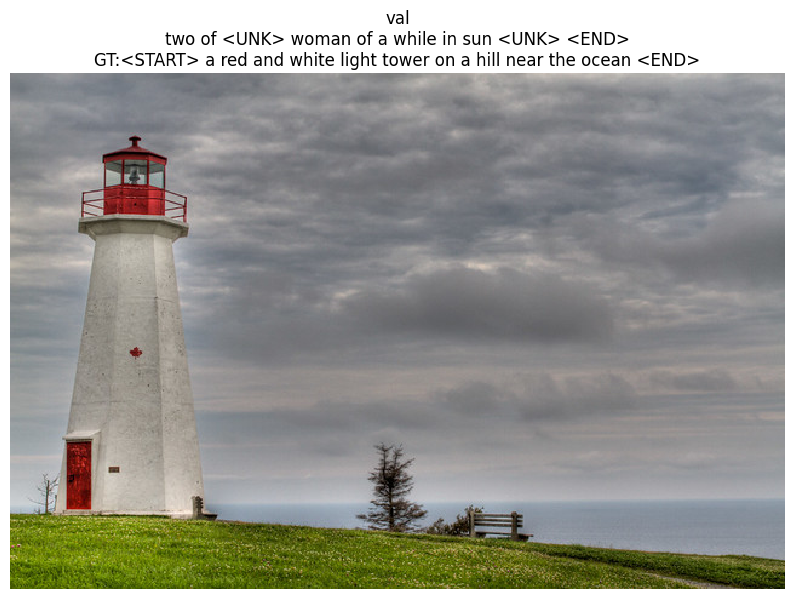

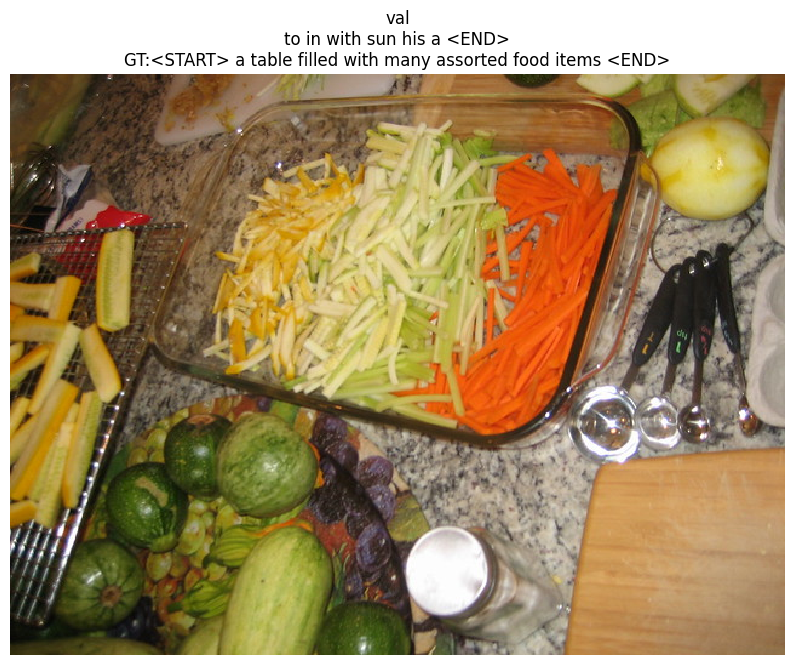

In [18]:
for split in ['train', 'val']:
    minibatch = get_coco_minibatch(coco_dataset, dataset_split=split, minibatch_size=2)
    gt_caption_labels, image_features, urls = minibatch
    gt_caption_labels = decode_captions(gt_caption_labels, data['idx_to_word'])

    sample_caption_labels = vision_decoder.sample(image_features)
    sample_caption_labels = decode_captions(sample_caption_labels, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_caption_labels, sample_caption_labels, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

Some of the captions are not very realistic. Mainly because RNN suffers from vanishing/ exploding gradients. That's why we'll see if LSTM will perform better

## Building the Core LSTM Logic


The Long-Short Term Memory (LSTM) RNN is a sophisticated variant of the vanilla RNN designed to address the challenges of training on long sequences. While vanilla RNNs often struggle with vanishing and exploding gradients due to repeated matrix multiplication, LSTMs overcome this limitation through an innovative gating mechanism.

**Architecture**

At each timestep $t$, an LSTM processes:
- An input vector $x_t\in\mathbb{R}^D$
- The previous hidden state $h_{t-1}\in\mathbb{R}^H$
- The previous cell state $c_{t-1}\in\mathbb{R}^H$ (unique to LSTM)

The learnable parameters consist of:
- Input-to-hidden matrix $W_x\in\mathbb{R}^{4H\times D}$
- Hidden-to-hidden matrix $W_h\in\mathbb{R}^{4H\times H}$
- Bias vector $b\in\mathbb{R}^{4H}$

**Forward Pass**

1. First, compute the activation vector $a\in\mathbb{R}^{4H}$:
   $$a=W_xx_t + W_hh_{t-1}+b$$

2. Split $a$ into four vectors of dimension $H$:
   - $a_i$: first $H$ elements (input gate)
   - $a_f$: second $H$ elements (forget gate)
   - $a_o$: third $H$ elements (output gate)
   - $a_g$: fourth $H$ elements (block input)

3. Apply nonlinear transformations:
   $$
   i = \sigma(a_i) \hspace{2pc}
   f = \sigma(a_f) \hspace{2pc}
   o = \sigma(a_o) \hspace{2pc}
   g = \tanh(a_g)
   $$
   where $\sigma$ is the elementwise sigmoid function and $\tanh$ is the elementwise hyperbolic tangent.

4. Update cell and hidden states:
   $$
   c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
   h_t = o\odot\tanh(c_t)
   $$
   where $\odot$ denotes elementwise multiplication.

**Implementation Note**

For efficient batch processing, we use:
- Input batches $X_t \in \mathbb{R}^{N\times D}$
- Transposed parameter matrices:
  - $W_x \in \mathbb{R}^{D \times 4H}$
  - $W_h \in \mathbb{R}^{H\times 4H}$

This allows efficient computation of activations $A \in \mathbb{R}^{N\times 4H}$ as:
$$A = X_t W_x + H_{t-1} W_h$$

### Forward Step Propagation Implementation:
Implement the forward pass for a single timestep of an LSTM in the `foward_propg_step_lstm` function in the file `model_layers.py`. This should be similar to the `foward_propg_step` function that you implemented above, but using the LSTM update rule instead.


In [19]:
# Test configuration for LSTM forward propagation
#
# This setup creates test data to validate the LSTM forward propagation step
# with predetermined values that should produce known outputs.

# Define network dimensions
BATCH_SIZE = 3    # Number of sequences processed simultaneously
INPUT_DIM = 4     # Dimension of input features
HIDDEN_DIM = 5    # Dimension of hidden state

# Generate input sequences using linear spacing
# Shape: (batch_size, input_dim)
input_features = np.linspace(
    start=-0.4,   # Starting value for sequence
    stop=1.2,     # Ending value for sequence
    num=BATCH_SIZE * INPUT_DIM
).reshape(BATCH_SIZE, INPUT_DIM)

# Generate previous hidden state using linear spacing
# Shape: (batch_size, hidden_dim)
hidden_state = np.linspace(
    start=-0.3,
    stop=0.7,
    num=BATCH_SIZE * HIDDEN_DIM
).reshape(BATCH_SIZE, HIDDEN_DIM)

# Generate previous cell state using linear spacing
# Shape: (batch_size, hidden_dim)
cell_state = np.linspace(
    start=-0.4,
    stop=0.9,
    num=BATCH_SIZE * HIDDEN_DIM
).reshape(BATCH_SIZE, HIDDEN_DIM)

# Generate input-to-hidden weight matrix
# Shape: (input_dim, 4 * hidden_dim) for the four LSTM gates
input_weights = np.linspace(
    start=-2.1,
    stop=1.3,
    num=4 * INPUT_DIM * HIDDEN_DIM
).reshape(INPUT_DIM, 4 * HIDDEN_DIM)

# Generate hidden-to-hidden weight matrix
# Shape: (hidden_dim, 4 * hidden_dim) for the four LSTM gates
hidden_weights = np.linspace(
    start=-0.7,
    stop=2.2,
    num=4 * HIDDEN_DIM * HIDDEN_DIM
).reshape(HIDDEN_DIM, 4 * HIDDEN_DIM)

# Generate bias terms for all gates
# Shape: (4 * hidden_dim,) for the four LSTM gates
gate_biases = np.linspace(
    start=0.3,
    stop=0.7,
    num=4 * HIDDEN_DIM
)

# Expected output values for validation
expected_next_hidden = np.asarray([
    [0.24635157, 0.28610883, 0.32240467, 0.35525807, 0.38474904],
    [0.49223563, 0.55611431, 0.61507696, 0.66844003, 0.7159181],
    [0.56735664, 0.66310127, 0.74419266, 0.80889665, 0.858299]
])

expected_next_cell = np.asarray([
    [0.32986176, 0.39145139, 0.451556, 0.51014116, 0.56717407],
    [0.66382255, 0.76674007, 0.87195994, 0.97902709, 1.08751345],
    [0.74192008, 0.90592151, 1.07717006, 1.25120233, 1.42395676]
])

# Perform forward propagation step
next_hidden, next_cell, cache = foward_propg_step_lstm(
    input_features,
    hidden_state,
    cell_state,
    input_weights,
    hidden_weights,
    gate_biases
)

# Compute and display errors
hidden_error = rel_error(expected_next_hidden, next_hidden)
cell_error = rel_error(expected_next_cell, next_cell)

print('Hidden state error: ', hidden_error)
print('Cell state error: ', cell_error)

Hidden state error:  5.7054131967097955e-09
Cell state error:  5.8143123088804145e-09


### Backward Step Propagation Implementation:
Implement the backpropagation calculation for one time step in LSTM within the file `model_layers.py`. Specifically, you need to code the `backwd_propg_step_lstm`  function. After you've written the implementation, validate it using the test suite, which will compare your gradients against numerically computed ones. Your implementation should be accurate - the difference between your analytical gradients and the numerical ones should be very small (approximately **`e-7` or less**).

In [20]:
np.random.seed(231)

# Dimensions
batch_size = 4
input_dim = 5
hidden_dim = 6

# Input and state tensors
input_features = np.random.randn(batch_size, input_dim)
prev_hidden_state = np.random.randn(batch_size, hidden_dim)
prev_cell_state = np.random.randn(batch_size, hidden_dim)

# Weight matrices and bias
input_weights = np.random.randn(input_dim, 4 * hidden_dim)
hidden_weights = np.random.randn(hidden_dim, 4 * hidden_dim)
lstm_bias = np.random.randn(4 * hidden_dim)

# Forward pass
next_hidden_state, next_cell_state, cache = foward_propg_step_lstm(
    input_features,
    prev_hidden_state,
    prev_cell_state,
    input_weights,
    hidden_weights,
    lstm_bias
)

# Gradients for backpropagation
d_next_hidden = np.random.randn(*next_hidden_state.shape)
d_next_cell = np.random.randn(*next_cell_state.shape)

# Lambda functions for numerical gradient checking
# For hidden state computations
compute_grad_input_h = lambda x: foward_propg_step_lstm(x, prev_hidden_state, prev_cell_state, input_weights, hidden_weights, lstm_bias)[0]
compute_grad_hidden_h = lambda h: foward_propg_step_lstm(input_features, h, prev_cell_state, input_weights, hidden_weights, lstm_bias)[0]
compute_grad_cell_h = lambda c: foward_propg_step_lstm(input_features, prev_hidden_state, c, input_weights, hidden_weights, lstm_bias)[0]
compute_grad_input_weights_h = lambda w: foward_propg_step_lstm(input_features, prev_hidden_state, prev_cell_state, w, hidden_weights, lstm_bias)[0]
compute_grad_hidden_weights_h = lambda w: foward_propg_step_lstm(input_features, prev_hidden_state, prev_cell_state, input_weights, w, lstm_bias)[0]
compute_grad_bias_h = lambda b: foward_propg_step_lstm(input_features, prev_hidden_state, prev_cell_state, input_weights, hidden_weights, b)[0]

# For cell state computations
compute_grad_input_c = lambda x: foward_propg_step_lstm(x, prev_hidden_state, prev_cell_state, input_weights, hidden_weights, lstm_bias)[1]
compute_grad_hidden_c = lambda h: foward_propg_step_lstm(input_features, h, prev_cell_state, input_weights, hidden_weights, lstm_bias)[1]
compute_grad_cell_c = lambda c: foward_propg_step_lstm(input_features, prev_hidden_state, c, input_weights, hidden_weights, lstm_bias)[1]
compute_grad_input_weights_c = lambda w: foward_propg_step_lstm(input_features, prev_hidden_state, prev_cell_state, w, hidden_weights, lstm_bias)[1]
compute_grad_hidden_weights_c = lambda w: foward_propg_step_lstm(input_features, prev_hidden_state, prev_cell_state, input_weights, w, lstm_bias)[1]
compute_grad_bias_c = lambda b: foward_propg_step_lstm(input_features, prev_hidden_state, prev_cell_state, input_weights, hidden_weights, b)[1]

# Numerical gradient computation
numerical_gradient = eval_num_grad_array

# Computing numerical gradients
d_input_num = numerical_gradient(compute_grad_input_h, input_features, d_next_hidden) + \
              numerical_gradient(compute_grad_input_c, input_features, d_next_cell)

d_hidden_num = numerical_gradient(compute_grad_hidden_h, prev_hidden_state, d_next_hidden) + \
               numerical_gradient(compute_grad_hidden_c, prev_hidden_state, d_next_cell)

d_cell_num = numerical_gradient(compute_grad_cell_h, prev_cell_state, d_next_hidden) + \
             numerical_gradient(compute_grad_cell_c, prev_cell_state, d_next_cell)

d_input_weights_num = numerical_gradient(compute_grad_input_weights_h, input_weights, d_next_hidden) + \
                     numerical_gradient(compute_grad_input_weights_c, input_weights, d_next_cell)

d_hidden_weights_num = numerical_gradient(compute_grad_hidden_weights_h, hidden_weights, d_next_hidden) + \
                      numerical_gradient(compute_grad_hidden_weights_c, hidden_weights, d_next_cell)

d_bias_num = numerical_gradient(compute_grad_bias_h, lstm_bias, d_next_hidden) + \
             numerical_gradient(compute_grad_bias_c, lstm_bias, d_next_cell)

# Backward pass
d_input, d_hidden, d_cell, d_input_weights, d_hidden_weights, d_bias = backwd_propg_step_lstm(
    d_next_hidden,
    d_next_cell,
    cache
)

# Error checking
print('Input gradient error: ', rel_error(d_input_num, d_input))
print('Hidden state gradient error: ', rel_error(d_hidden_num, d_hidden))
print('Cell state gradient error: ', rel_error(d_cell_num, d_cell))
print('Input weights gradient error: ', rel_error(d_input_weights_num, d_input_weights))
print('Hidden weights gradient error: ', rel_error(d_hidden_weights_num, d_hidden_weights))
print('Bias gradient error: ', rel_error(d_bias_num, d_bias))


Input gradient error:  5.833093013472354e-10
Hidden state gradient error:  3.4168728051126624e-10
Cell state gradient error:  1.5221723979041107e-10
Input weights gradient error:  1.6933643922734908e-09
Hidden weights gradient error:  2.7311400266248628e-08
Bias gradient error:  1.7349356733443412e-10


### Complete Forward Implementation:


Now let's implement `forward_propg_single_lstm` in `model_layers.py`. This function should:
1. Process sequence data using your existing `foward_propg_step_lstm` function
2. Pass provided tests with **error margin ≤ 1e-7**


In [21]:
# Define dimensions
batch_size = 2
input_dim = 5      # Previously D
hidden_dim = 4     # Previously H
sequence_length = 3 # Previously seqlen

# Generate input sequence data
input_sequence = np.linspace(
    -0.4, 0.6,
    num=batch_size * sequence_length * input_dim
).reshape(batch_size, sequence_length, input_dim)

# Initialize hidden state
initial_hidden_state = np.linspace(
    -0.4, 0.8,
    num=batch_size * hidden_dim
).reshape(batch_size, hidden_dim)

# Define LSTM parameters
# Weights for input-to-hidden connections (for input, forget, output, and cell gates)
input_weights = np.linspace(
    -0.2, 0.9,
    num=4 * input_dim * hidden_dim
).reshape(input_dim, 4 * hidden_dim)

# Weights for hidden-to-hidden connections
hidden_weights = np.linspace(
    -0.3, 0.6,
    num=4 * hidden_dim * hidden_dim
).reshape(hidden_dim, 4 * hidden_dim)

# Bias terms for all gates
lstm_bias = np.linspace(0.2, 0.7, num=4 * hidden_dim)

# Forward pass through LSTM
hidden_states, cache = forward_propg_single_lstm(
    input_sequence,
    initial_hidden_state,
    input_weights,
    hidden_weights,
    lstm_bias
)

# Expected output for validation
expected_hidden_states = np.asarray([
    [
        [0.01764008, 0.01823233, 0.01882671, 0.0194232],
        [0.11287491, 0.12146228, 0.13018446, 0.13902939],
        [0.31358768, 0.33338627, 0.35304453, 0.37250975]
    ],
    [
        [0.45767879, 0.4761092, 0.4936887, 0.51041945],
        [0.6704845, 0.69350089, 0.71486014, 0.7346449],
        [0.81733511, 0.83677871, 0.85403753, 0.86935314]
    ]
])

# Check error between expected and actual output
print('Hidden state error: ', rel_error(expected_hidden_states, hidden_states))

Hidden state error:  8.610537442272635e-08




### Complete Backward Implementation:

Implement the backpropagation in the `model_layers.py` file by coding the `backwd_propg_single_lstm` function. It should work by calling `backwd_propg_step_lstm` repeatedly for each timestep in the sequence.
To verify your implementation, run the tests - they'll check if your gradients are correct. Your implementation should be precise enough that the difference between your calculated gradients and the numerically computed ones is around **10^-8 or smaller**. Note on gradient checking:
Weight hidden gradient (`grad_weight_hidden`) accuracy: **error ≤ 1e-6**

In [22]:
np.random.seed(231)

batch_size, input_dim, seq_length, hidden_dim = 2, 3, 10, 6

# Input data and initial hidden state
input_data = np.random.randn(batch_size, seq_length, input_dim)
hidden_init = np.random.randn(batch_size, hidden_dim)

# LSTM parameters
weight_input = np.random.randn(input_dim, 4 * hidden_dim)
weight_hidden = np.random.randn(hidden_dim, 4 * hidden_dim)
biases = np.random.randn(4 * hidden_dim)

# Forward pass
output, cache = forward_propg_single_lstm(input_data, hidden_init,
                                       weight_input, weight_hidden, biases)

# Gradient of loss with respect to output
gradient_output = np.random.randn(*output.shape)

# Backward pass
grad_input, grad_hidden_init, grad_weight_input, grad_weight_hidden, grad_biases = \
   backwd_propg_single_lstm(gradient_output, cache)

# Lambda functions for numeric gradient checking
f_input = lambda x: forward_propg_single_lstm(x, hidden_init, weight_input, weight_hidden, biases)[0]
f_hidden = lambda h: forward_propg_single_lstm(input_data, h, weight_input, weight_hidden, biases)[0]
f_weight_input = lambda w: forward_propg_single_lstm(input_data, hidden_init, w, weight_hidden, biases)[0]
f_weight_hidden = lambda w: forward_propg_single_lstm(input_data, hidden_init, weight_input, w, biases)[0]
f_biases = lambda b: forward_propg_single_lstm(input_data, hidden_init, weight_input, weight_hidden, b)[0]

# Compute numeric gradients
grad_input_num = eval_num_grad_array(f_input, input_data, gradient_output)
grad_hidden_num = eval_num_grad_array(f_hidden, hidden_init, gradient_output)
grad_weight_input_num = eval_num_grad_array(f_weight_input, weight_input, gradient_output)
grad_weight_hidden_num = eval_num_grad_array(f_weight_hidden, weight_hidden, gradient_output)
grad_biases_num = eval_num_grad_array(f_biases, biases, gradient_output)

# Print relative errors
print('Input gradient error: ', rel_error(grad_input_num, grad_input))
print('Hidden state gradient error: ', rel_error(grad_hidden_num, grad_hidden_init))
print('Input weight gradient error: ', rel_error(grad_weight_input_num, grad_weight_input))
print('Hidden weight gradient error: ', rel_error(grad_weight_hidden_num, grad_weight_hidden))
print('Biases gradient error: ', rel_error(grad_biases_num, grad_biases))

Input gradient error:  7.1480958161034e-10
Hidden state gradient error:  2.3791401549917165e-08
Input weight gradient error:  1.0057877119886127e-09
Hidden weight gradient error:  6.064216037522062e-07
Biases gradient error:  6.252306209370124e-10


### Final Model

In `rnn_model.py`:
1. Add LSTM handling when `self.cell_type == 'lstm'`
2. Implement in less than 10 lines of code
3. Run tests - **expected error: ≤ 1e-10**

In [23]:
# Model dimensions
batch_size = 10
feature_dim = 20      # Previously D
word_embed_dim = 30   # Previously W
hidden_dim = 40       # Previously H

# Dictionary mapping words to indices
vocabulary = {
    '<NULL>': 0,
    'cat': 2,
    'dog': 3
}
vocab_size = len(vocabulary)
caption_length = 13   # Previously seqlen

# Initialize the image captioning model
captioning_model = ImageCaptioningRNN(
    word_to_idx=vocabulary,
    input_dim=feature_dim,
    wordvec_dim=word_embed_dim,
    hidden_dim=hidden_dim,
    cell_type='lstm',
    dtype=np.float64
)

# Initialize model parameters with evenly spaced values
for param_name, param_value in captioning_model.params.items():
    captioning_model.params[param_name] = np.linspace(
        -1.4,
        1.3,
        num=param_value.size
    ).reshape(*param_value.shape)

# Generate test input features (e.g., image embeddings)
image_features = np.linspace(
    -0.5,
    1.7,
    num=batch_size * feature_dim
).reshape(batch_size, feature_dim)

# Generate test captions (cycling through vocabulary indices)
test_captions = (
    np.arange(batch_size * caption_length) % vocab_size
).reshape(batch_size, caption_length)

# Compute loss and gradients
loss, gradients = captioning_model.loss(image_features, test_captions)

# Validation
expected_loss = 9.82445935443

# Print results
print('Computed loss: ', loss)
print('Expected loss: ', expected_loss)
print('Absolute difference: ', abs(loss - expected_loss))

Computed loss:  9.82445935443226
Expected loss:  9.82445935443
Absolute difference:  2.261302256556519e-12




### Testing Model on Small Dataset

Run the below cell to use the `ImageCaptioningTrainerEngine` class from `trainer.py` to train your model. Run the code below to verify it can overfit on 100 training examples - the loss should drop to **less than 0.5**.

base dir  /content/datasets/coco_captioning
(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.765194
(Iteration 21 / 100) loss: 29.961398
(Iteration 31 / 100) loss: 14.195622
(Iteration 41 / 100) loss: 5.883439
(Iteration 51 / 100) loss: 1.804413
(Iteration 61 / 100) loss: 0.703821
(Iteration 71 / 100) loss: 0.289652
(Iteration 81 / 100) loss: 0.304331
(Iteration 91 / 100) loss: 0.160138


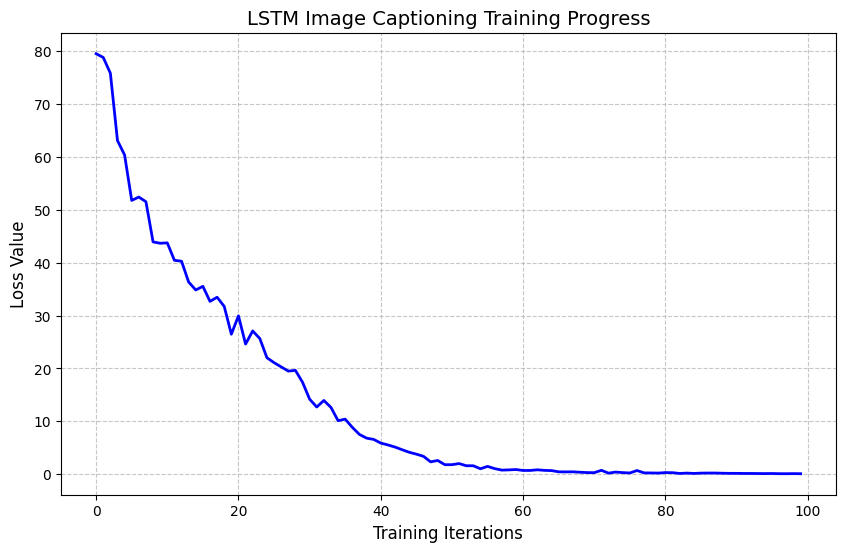

In [24]:
# Set random seed for reproducibility
np.random.seed(231)

# Load a small subset of COCO dataset with PCA-reduced features
training_dataset = load_coco_dataset(
    base_dir=BASE_DIR,
    max_train=50,
    pca_features=True
)

# Initialize LSTM image captioning model
lstm_captioning_model = ImageCaptioningRNN(
    cell_type='lstm',
    word_to_idx=data['word_to_idx'],
    input_dim=data['train_features'].shape[1],
    hidden_dim=512,         # Size of LSTM hidden state
    wordvec_dim=256,       # Dimension of word embeddings
    dtype=np.float32
)

# Configure training parameters
training_config = {
    'learning_rate': 5e-3,
}

# Initialize training engine
captioning_trainer = ImageCaptioningTrainerEngine(
    model=lstm_captioning_model,
    data=training_dataset,
    update_opt='adam',           # Using Adam optimizer
    n_epoch=50,                  # Number of training epochs
    batch_size=25,              # Samples per batch
    opt_config=training_config,
    lr_decay=0.995,             # Learning rate decay factor
    ver=True,                   # Enable verification
    print_all=10                # Print frequency
)

# Train the model
captioning_trainer.train()

# Generate performance visualization
plt.figure(figsize=(10, 6))
plt.plot(captioning_trainer.loss_history, color='blue', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Training Iterations', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title('LSTM Image Captioning Training Progress', fontsize=14)
plt.show()

Print final training loss. You should see a final loss of less than 0.5.

In [25]:
print('Expected Final loss: ', captioning_trainer.loss_history[-1])

Expected Final loss:  0.0897806880435989


### Generation at Test Time
In `rnn_model.py`:
1. Complete the code of `sample` function
2. Test by generating text using:
    - Training data (should produce coherent results)
    - Validation data (lower quality because we are overfitting)

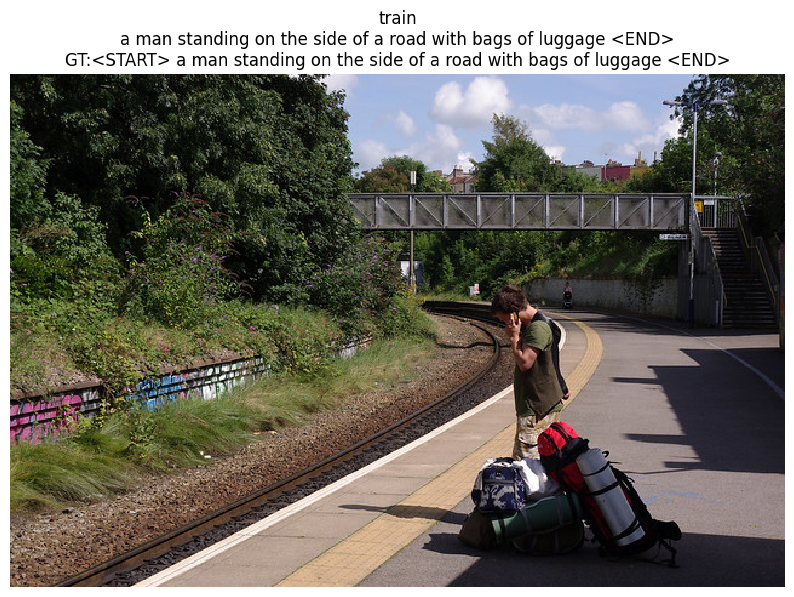

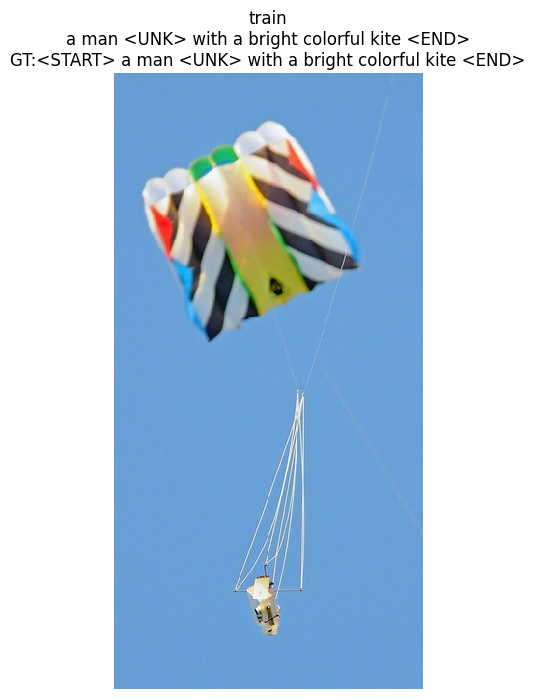

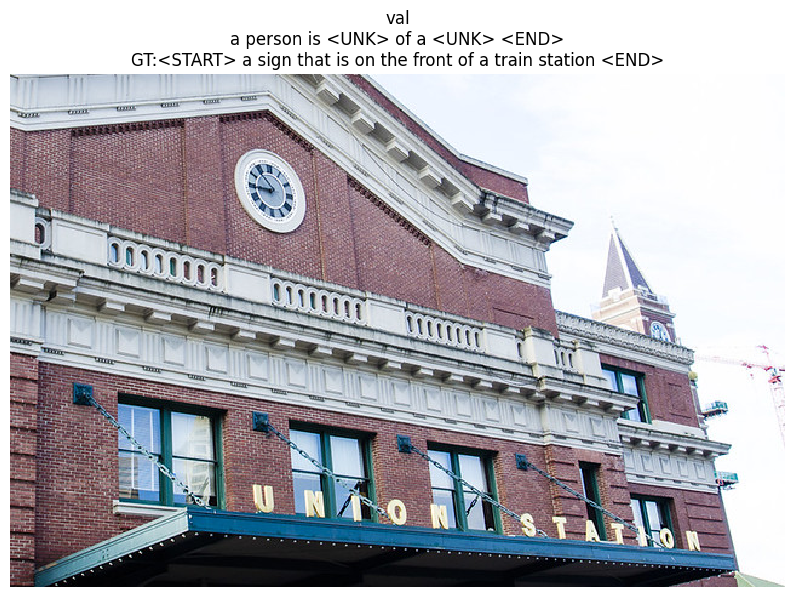

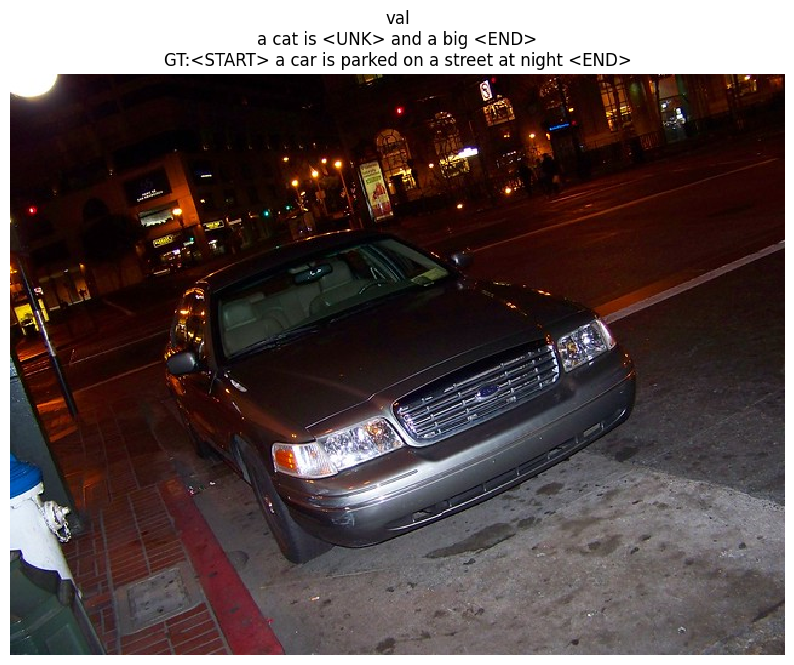

In [26]:
for split in ['train', 'val']:
    minibatch = get_coco_minibatch(training_dataset, dataset_split=split, minibatch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = lstm_captioning_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

The first caption was good, however the others were not really. Training sequential models is hard in general, but we were able to decrease a lot the training error.